# Week 4: Handling Complex Images - Happy or Sad Dataset

In this assignment you will be using the happy or sad dataset, which contains 80 images of emoji-like faces, 40 happy and 40 sad.

Create a convolutional neural network that trains to 99.9% accuracy on these images,  which cancels training upon hitting this training accuracy threshold.

#### TIPS FOR SUCCESSFUL GRADING OF YOUR ASSIGNMENT:

- All cells are frozen except for the ones where you need to submit your solutions or when explicitly mentioned you can interact with it.

- You can add new cells to experiment but these will be omitted by the grader, so don't rely on newly created cells to host your solution code, use the provided places for this.

- You can add the comment # grade-up-to-here in any graded cell to signal the grader that it must only evaluate up to that point. This is helpful if you want to check if you are on the right track even if you are not done with the whole assignment. Be sure to remember to delete the comment afterwards!

- Avoid using global variables unless you absolutely have to. The grader tests your code in an isolated environment without running all cells from the top. As a result, global variables may be unavailable when scoring your submission. Global variables that are meant to be used will be defined in UPPERCASE.

- To submit your notebook, save it and then click on the blue submit button at the beginning of the page.

In [1]:
import os
import base64
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2024-09-27 13:46:41.039607: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-27 13:46:41.042429: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-27 13:46:41.083155: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-27 13:46:41.865147: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import unittests

## Load and explore the data

Begin by taking a look at some images of the dataset.

All the images are contained within the `./data/` directory, notice that in this context the dot (`.`) means "the current directory". 

This `data/` directory contains two subdirectories `happy/` and `sad/` and each image is saved under the subdirectory related to the class it belongs to, take a look at the following tree for a more detailed view:

```
.
└── data/
    ├── happy/
    │   ├── happy_image_1.png
    │   ├── happy_image_2.png
    │   └── ...
    └── sad/
        ├── sad_image_1.png
        ├── sad_image_2.png
        └── ...
```

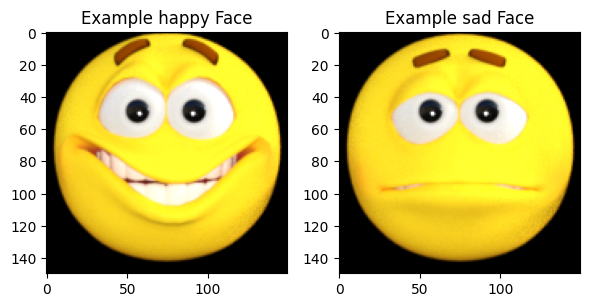

In [3]:
BASE_DIR = "./data/"
happy_dir = os.path.join(BASE_DIR, "happy/")
sad_dir = os.path.join(BASE_DIR, "sad/")

fig, axs = plt.subplots(1, 2, figsize=(6, 6))
axs[0].imshow(tf.keras.utils.load_img(f"{os.path.join(happy_dir, os.listdir(happy_dir)[0])}"))
axs[0].set_title('Example happy Face')

axs[1].imshow(tf.keras.utils.load_img(f"{os.path.join(sad_dir, os.listdir(sad_dir)[0])}"))
axs[1].set_title('Example sad Face')

plt.tight_layout()

It is cool to be able to see examples of the images to better understand the problem-space you are dealing with. 

However there is still some relevant information that is missing such as the resolution of the image (although matplotlib renders the images in a grid providing a good idea of these values) and the maximum pixel value (this is important for normalizing these values). For this you can use some `tf.keras` utility functions as shown in the next cell:

In [4]:
# Load the first example of a happy face
sample_image  = tf.keras.utils.load_img(f"{os.path.join(happy_dir, os.listdir(happy_dir)[0])}")

# Convert the image into its numpy array representation
sample_array = tf.keras.utils.img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

print(f"The maximum pixel value used is: {np.max(sample_array)}")

Each image has shape: (150, 150, 3)
The maximum pixel value used is: 255.0


Looks like the images have a resolution of 150x150. **This is very important because this will be the input size of the first layer in your network.** 

**The last dimension refers to each one of the 3 RGB (Red, Green, Blue) channels that are used to represent colored images.** So far, in the previous assignments you used black and white images so it is time to introduce some color!

## Defining the callback

Since you already have coded the callback responsible for stopping training (once a desired level of accuracy is reached) in the previous two assignments this time it is already provided so you can focus on the other steps:

In [5]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['accuracy'] >= 0.999:
            self.model.stop_training = True
            print("\nReached 99.9% accuracy so cancelling training!")

So far you have implemented an `EarlyStoppingCallback` by customizing the `on_epoch_end` method but there is a version of this callback already available within `tf.keras`. You might want to check out the [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback, which has some extra functionality such as allowing you to save the best weights for your model and while at it take a look at all the other cool callbacks in the [docs](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks).

## Exercise 1: training_dataset

Up until now, in the previous 3 assignments you have used numpy arrays to hold your training data, which is a valid input for Tensorflow models. However it is often a better practice to use `tf.data.Dataset` since this provides extra functionality. You can even create these out of numpy arrays and many other data sources. Be sure to check the [docs](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) to learn more about this, as you will use this extensively in the next courses of the specialization.

You have covered some ground already and it is now time for your first task! 

You will now use the images of happy and sad faces to create your training dataset. Previously you used some `tf.keras` utility functions to work with image data. Now you will use one of the most powerful ones which is `image_dataset_from_directory`. Be sure to check out the [docs](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) to see how this function is used and how its behaviour can be tweaked by providing different arguments for it. Remember to scale the images using a [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling) layer and to apply this to the dataset by using the [map](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) method as you saw in the ungraded labs! 


In [8]:
# GRADED FUNCTION: training_dataset

def training_dataset():
    """Creates the training dataset out of the training images. Pixel values should be normalized.

    Returns:
        tf.data.Dataset: The dataset including the images of happy and sad faces.
    """
    
    ### START CODE HERE ###

    # Specify the function to load images from a directory and pass in the appropriate arguments:
    # - directory: should be a relative path to the directory containing the data. 
    #              You may hardcode this or use the previously defined global variable.
    # - image_size: set this equal to the resolution of each image (excluding the color dimension)
    # - batch_size: number of images the generator yields when asked for a next batch. Set this to 10.
    # - class_mode: How the labels are represented. Should be one of "binary", "categorical" or "int".
    #               Pick the one that better suits here given that the labels can only be two different values.
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=BASE_DIR,
        image_size=(150,150),
        batch_size=10,
        label_mode="binary"
    )

    # Define the rescaling layer (passing in the appropriate parameters)
    rescale_layer = tf.keras.layers.Rescaling(1./255)

    # Apply the rescaling by using the map method and a lambda
    train_dataset_scaled = train_dataset.map(lambda image, label: (rescale_layer(image), label))
    
    ### END CODE HERE ###

    return train_dataset_scaled
    

In [11]:
# Save your generator in a variable
train_data = training_dataset()

for images, labels in train_data.take(1):
    print(f"Range for pixel values: {np.min(images[0]), np.max(images[0])}")

print(f"train_data is an instance of tf.data.Dataset: {isinstance(train_data, tf.data.Dataset)}")

Found 80 files belonging to 2 classes.
Range for pixel values: (0.0, 1.0)
train_data is an instance of tf.data.Dataset: True


2024-09-27 15:20:07.693765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


**Expected Output:**
```
Found 80 files belonging to 2 classes.
Range for pixel values: (0.0, 1.0)
train_data is an instance of tf.data.Dataset: True
```

In [12]:
# Test your code!
unittests.test_train_data(train_data)

 All tests passed!


2024-09-27 15:20:28.170507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Exercise 2: create_and_compile_model

Now that you have the training data ready it is time to define the model you will use to classify the happy and sad faces.

**Your model should achieve an accuracy of 99.9% or more before 15 epochs to pass this assignment.**

**Hints:**
- The [Input](https://www.tensorflow.org/api_docs/python/tf/keras/Input) of your model should account for the shape of the data, which in this case is the size of each image plus the color dimension.



- The last layer of your network should take into account the number of classes you are trying to predict and be compatible with the `label_mode` you defined in the previous exercise.

- The selection of the loss function should take into consideration the `label_mode` you defined in the previous exercise and the last layer of your network. For a list of available loss functions click [here](https://www.tensorflow.org/api_docs/python/tf/keras/losses).

- Remember to set the `accuracy` metric as the callback expects it.

- You can try any architecture for the network but keep in mind that the model will work best with 3 convolutional layers. 


- In case you need extra help you can check out some tips at the end of this notebook.

In [14]:
# GRADED FUNCTION: create_and_compile_model

def create_and_compile_model():
    """Creates, compiles and trains the model to predict happy from sad faces.

    Returns:
        tf.keras.Model: The model that will be trained to predict predict happy and sad faces.
    """

    ### START CODE HERE ###

    # Define the model
    model = tf.keras.models.Sequential([ 
		tf.keras.Input(shape=(150,150,3)),
        tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
        tf.keras.layers.MaxPool2D((2,2)),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPool2D((2,2)),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPool2D((2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]) 

    # Compile the model
    # Remember to set an appropriate loss function, optimizer and metrics 
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
        metrics=['accuracy']
    ) 
    
    ### END CODE HERE ###

    return model

The next cell allows you to check the number of total and trainable parameters of your model and prompts a warning in case these exceeds those of a reference solution, this serves the following 3 purposes listed in order of priority:

- Helps you prevent crashing the kernel during training.

- Helps you avoid longer-than-necessary training times.

- Provides a reasonable estimate of the size of your model. In general you will usually prefer smaller models given that they accomplish their goal successfully.

**Notice that this is just informative** and may be very well below the actual limit for size of the model necessary to crash the kernel. So even if you exceed this reference you are probably fine. However, **if the kernel crashes during training or it is taking a very long time and your model is larger than the reference, come back here and try to get the number of parameters closer to the reference.**

In [15]:
# Save untrained model in a variable
model = create_and_compile_model()

# Check parameter count against a reference solution
unittests.parameter_count(model)

Your model has 2,391,329 total parameters and the reference is 21,000,000. You are good to go!

Your model has 2,391,329 trainable parameters and the reference is 21,000,000. You are good to go!


Check that the architecture you used is compatible with the dataset:

In [16]:
# Get the first batch of images and labels
for images, labels in train_data.take(1):
	example_batch_images = images
	example_batch_labels = labels

try:
	model.evaluate(example_batch_images, example_batch_labels, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function, last layer and label_mode are compatible with one another.")
else:
	predictions = model.predict(example_batch_images, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

2024-09-27 15:42:04.859471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


predictions have shape: (10, 1)


**Expected Output:**
```
predictions have shape: (batch_size, n_units)
```

Where `batch_size` is the one you defined in the previous exercise (should be 10) and `n_units` is the number of units of the last layer of your model.

In [17]:
# Test your code!
unittests.test_create_and_compile_model(create_and_compile_model)

 All tests passed!


Notice that when using the `fit` method to train the model, you can pass in the whole `train_data` without explicitly separating features from labels. This is because `train_data` is a `tf.data.Dataset` and this operation is supported for objects of this class. For more info click [here](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit).

In [18]:
# Get the training history from your model
training_history = model.fit(
	x=train_data,
    epochs=15,
    callbacks=[EarlyStoppingCallback()]
)

Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.5827 - loss: 1.6413
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.6860 - loss: 0.5536
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.6387 - loss: 0.6703
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9372 - loss: 0.2755
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.9528 - loss: 0.1791
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9330 - loss: 0.1819
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.9546 - loss: 0.1330
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9844 - loss: 0.1351
Epoch 9/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.9285 - loss: 0.1248
Epoch 10/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9888 - loss: 0.0330
Epoch 11/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.9888 - loss: 0.0536
Epoch 12/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9888 - lo

**Expected Output:**

`Reached 99.9% accuracy so cancelling training!` printed out before reaching 15 epochs.

In [19]:
# Test your code!
unittests.test_training_history(training_history)

 All tests passed!


## Need more help?

Run the following cell to see some extra tips for the model's architecture and compilation parameters:

In [20]:
encoded_answer = "ClNvbWUgaGVscGZ1bCB0aXBzIGluIGNhc2UgeW91IGFyZSBzdHVjazoKCiAgICAtIFRoZSBpbnB1dCBzaG91bGQgYmUgYSB0Zi5rZXJhcy5JbnB1dCB3aXRoIGEgc2hhcGUgdGhhdCBtYXRjaGVzIAogICAgdGhhdCBvZiBldmVyeSBpbWFnZSBpbiB0aGUgdHJhaW5pbmcgc2V0IChpbmNsdWRpbmcgdGhlIGNvbG9yIGRpbWVuc2lvbikKICAgIAogICAgLSBBIGdvb2QgbGF5ZXIgKGFmdGVyIHRoZSBJbnB1dCkgd291bGQgYmUgYSBDb252MkQgbGF5ZXIKICAgIAogICAgLSBUaGUgbW9kZWwgd2lsbCB3b3JrIGJlc3Qgd2l0aCAzIGNvbnZvbHV0aW9uYWwgbGF5ZXJzCiAgICAKICAgIC0gVGhlcmUgc2hvdWxkIGJlIGEgRmxhdHRlbiBsYXllciBpbiBiZXR3ZWVuIGNvbnZvbHV0aW9uYWwgYW5kIGRlbnNlIGxheWVycwogICAgCiAgICAtIFRoZSBmaW5hbCBsYXllciBzaG91bGQgYmUgYSBEZW5zZSBsYXllciB3aXRoIHRoZSBudW1iZXIgb2YgdW5pdHMgYW5kIAogICAgYWN0aXZhdGlvbiBmdW5jdGlvbiB0aGF0IHN1cHBvcnRzIGJpbmFyeSBjbGFzc2lmaWNhdGlvbi4KCiAgICAtIEFkYW0gaXMgYSBnb29kIG9wdGltaXplciBpbiB0aGlzIGNhc2UuCgogICAgLSBBYm91dCBsb3NzIGZ1bmN0aW9uczoKCiAgICAgICAgLSBTcGFyc2VDYXRlZ29yaWNhbENyb3NzZW50cm9weSB3aWxsIHJlcXVpcmUgbGFiZWxfbW9kZSB0byBiZSAnaW50JyBvciAnYmluYXJ5JyAKICAgICAgICBhbmQgdGhlIGxhc3QgbGF5ZXIgc2hvdWxkIGhhdmUgdHdvIHVuaXRzIHdpdGggYSAnc29mdG1heCcgYWN0aXZhdGlvbiBmdW5jdGlvbi4KCiAgICAgICAgLSBCaW5hcnlDcm9zc2VudHJvcHkgd2lsbCByZXF1aXJlIGxhYmVsX21vZGUgdG8gYmUgJ2ludCcgb3IgJ2JpbmFyeScgCiAgICAgICAgYW5kIHRoZSBsYXN0IGxheWVyIHNob3VsZCBoYXZlIG9ubHkgb25lIHVuaXQgd2l0aCBhbiBhY3RpdmF0aW9uIGZ1bmN0aW9uIHN1Y2ggYXMgJ3NpZ21vaWQnLgoKICAgICAgICAtIENhdGVnb3JpY2FsQ3Jvc3NlbnRyb3B5IHdpbGwgcmVxdWlyZSBsYWJlbF9tb2RlIHRvIGJlICdjYXRlZ29yaWNhbCcKICAgICAgICBhbmQgdGhlIGxhc3QgbGF5ZXIgc2hvdWxkIGhhdmUgdHdvIHVuaXRzIHdpdGggYSAnc29mdG1heCcgYWN0aXZhdGlvbiBmdW5jdGlvbi4K=="
encoded_answer = encoded_answer.encode('ascii')
answer = base64.b64decode(encoded_answer)
answer = answer.decode('ascii')

print(answer)


Some helpful tips in case you are stuck:

    - The input should be a tf.keras.Input with a shape that matches 
    that of every image in the training set (including the color dimension)
    
    - A good layer (after the Input) would be a Conv2D layer
    
    - The model will work best with 3 convolutional layers
    
    - There should be a Flatten layer in between convolutional and dense layers
    
    - The final layer should be a Dense layer with the number of units and 
    activation function that supports binary classification.

    - Adam is a good optimizer in this case.

    - About loss functions:

        - SparseCategoricalCrossentropy will require label_mode to be 'int' or 'binary' 
        and the last layer should have two units with a 'softmax' activation function.

        - BinaryCrossentropy will require label_mode to be 'int' or 'binary' 
        and the last layer should have only one unit with an activation function such as 'sigmoid'.

        - CategoricalC

**Congratulations on finishing the last assignment of this course!**

You have successfully implemented a CNN to assist you in the classification task for complex images. Nice job!

**Keep it up!**